X_train.shape=(6000, 23, 23); X_test.shape=(1165, 23, 23)
y_train.shape=(6000,); y_test.shape=(1165,)


(array([  93.,  526., 1235., 1970., 1463.,  544.,  126.,   31.,    9.,
           3.]),
 array([-2192.   , -2013.288, -1834.576, -1655.864, -1477.152, -1298.44 ,
        -1119.728,  -941.016,  -762.304,  -583.592,  -404.88 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

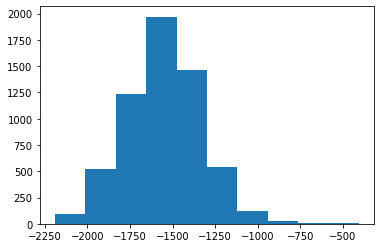

In [41]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax

data = np.load("data/qm7.npz")
X_train, X_test = np.split(data['X'], [6000])
y_train, y_test = np.split(data['T'].flatten(), [6000])
print(f"{X_train.shape=}; {X_test.shape=}")
print(f"{y_train.shape=}; {y_test.shape=}")

plt.figure()
plt.hist(y_train)

In [46]:
def mlp(params, x):
    for ind_layer, (weights, bias) in enumerate(params):
        x = x @ weights + bias
        if ind_layer != (len(params) - 1):
            x = jnp.tanh(x)
    return x

def init_mlp(n_neurons, input_dim):
    params = []
    for ind_layer in range(len(n_neurons)):
        if ind_layer == 0:
            dim_in = input_dim
        else:
            dim_in = n_neurons[ind_layer-1]
        dim_out = n_neurons[ind_layer]

        w_init = np.random.normal(loc=0, scale=2/(dim_in + dim_out), size=(dim_in, dim_out))
        b_init = np.zeros(shape=(dim_out,))
        params.append((w_init, b_init))
    return params

def model(params, x):
    x = jnp.linalg.eigvalsh(x)
    x = jnp.sort(x, axis=-1)
    y = mlp(params, x)
    return y.flatten()

def loss_func(params, x, y_target):
    y_pred = model(params, x)
    residual = y_pred - y_target
    return jnp.mean(residual**2)

@jax.jit
def training_step(params, x, y_target, learning_rate):
    loss, grad = jax.value_and_grad(loss_func, argnums=0)(params, x, y_target)
    param_update = jax.tree_map(lambda g: -learning_rate * g, grad)
    new_params = jax.tree_map(jnp.add, params, param_update)
    return loss, new_params

def make_batches(x, y, n_batches):
    indices = np.random.permutation(len(x))
    x = x[indices]
    y = y[indices]
    return np.split(x, n_batches), np.split(y, n_batches)

n_neurons_per_layer = [500, 500, 200, 100, 1]
learning_rate = 1e-4
params = init_mlp(n_neurons_per_layer, input_dim=X_train.shape[-1])

loss_values = []
for n_epoch in range(20):
    batches_x, batches_y = make_batches(X_train, y_train, 100)
    for batch_x, batch_y in zip(batches_x, batches_y):
        loss, params = training_step(params, batch_x, batch_y, learning_rate)
        loss_values.append(loss)
    print(f"epoch {n_epoch:<3d}, loss = {loss:.1f}")

epoch 0  , loss = 123812.9
epoch 1  , loss = 51735.0
epoch 2  , loss = 53442.1
epoch 3  , loss = 60106.2
epoch 4  , loss = 53295.6
epoch 5  , loss = 42574.0
epoch 6  , loss = 44195.7
epoch 7  , loss = 38861.8
epoch 8  , loss = 37223.3
epoch 9  , loss = 49549.5
epoch 10 , loss = 37322.9
epoch 11 , loss = 44548.0
epoch 12 , loss = 74957.3
epoch 13 , loss = 44815.6
epoch 14 , loss = 48902.9
epoch 15 , loss = 55335.9
epoch 16 , loss = 69338.5
epoch 17 , loss = 50292.9
epoch 18 , loss = 39181.1
epoch 19 , loss = 62824.8


Text(0, 0.5, 'Predicted [kcal/mol]')

<Figure size 432x288 with 0 Axes>

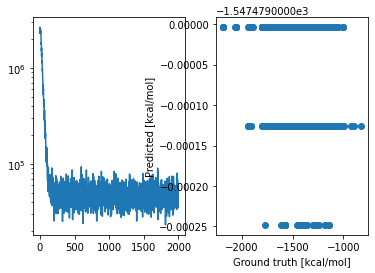

In [48]:
y_test_predicted = model(params, X_test)

plt.figure()
fig, axes = plt.subplots(1,2)
axes[0].semilogy(loss_values)
axes[1].scatter(y_test, y_test_predicted)
axes[1].set_xlabel("Ground truth [kcal/mol]")
axes[1].set_ylabel("Predicted [kcal/mol]")









